# Stimulus Generation: Scrambled Faces
The problem: Generate 'Scrambled Faces' as control stimuli like in [Rayson, Bonaiuto, Ferrari, & Murray (2016)](http://www.sciencedirect.com/science/article/pii/S1878929315301067):
> The scrambled versions of each video were produced by dividing the face region into square blocks (18 × 18 pixels), randomly shuffling these blocks in the first frame of the video, and then applying the same transformation to each subsequent frame.

Using the ADFES database, their frames look like this:
<img src="./rayson_large.JPG" width="200px" height="222px" />

We need to apply the same concept to the videos generated from the RaFD. The process solving this problem appears to have six steps:

1. extract frame from video
2. find face area in first frame
3. generate grid of 18px x 18xp (or, rather, 17x17, see below) blocks in that area
4. randomize position of each block in the grid
5. apply 3 & 4 to remaining frames
6. create video from manipulated frames

So far, Step 1 can be considered solved and I think completion of Step 2 is not far away. Of course, we will need an additional step: in the movement frames, we will need to make a geometric shape (triangle) appear that indicates the response mapping.

This is all done in Python. First, a number of modules need to be imported, most importantly OpenCV (cv2), which does most of the heavy lifting. facemorpher is a module that offers a nice interface to the STASM algorithm that does the facial feature extraction.


In [84]:
import os
import math

import numpy as np
from matplotlib import pyplot as plt

import cv2
from facemorpher import locator # we should get rid of this in the future and interface a STASM binary directly via system call

%matplotlib inline

## Step 1: Extract the first frame
For now, we will only extract the first frame of each video. Extracting the other 17 is trivial.

In [3]:
def extract_first_frame(vid, img='auto'):
    bn = os.path.basename(vid)
    bn = os.path.splitext(bn)[0]
    vid_folder = os.path.dirname(vid)
    vid_folder_par = os.path.dirname(vid_folder)
    vidcap = cv2.VideoCapture(vid)
    success, image = vidcap.read()
    if success:
        if img == 'auto':
            out_dir = os.path.join(vid_folder_par, 'img/')
            img = os.path.join(out_dir, bn + '_frame_1.jpg')
        out_dir = os.path.dirname(img)   
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)    
        cv2.imwrite(img, image)
    return success
    
def batch_extract_first_frame(vid_dir, img_dir):
    n = 0
    vid_list = os.listdir(vid_dir)
    for f in vid_list:
        bn = os.path.splitext(f)[0]
        img = os.path.join(img_dir, bn + '_frame_1.jpg')
        # print "extracting first frame from ", f
        vid = os.path.join(vid_dir, f)
        success = extract_first_frame(vid, img)
        if success:
            n += 1
    print "%d of %d videos successfully converted" % (n, len(vid_list))
    
vid_dir = './vid'
img_dir = './img'
batch_extract_first_frame(vid_dir, img_dir)

79 of 79 videos successfully converted


This works just the way it should:
<img src="./img/ekl99m09_frame_1.jpg" width="200px" height="222px" />


## Step 2: Find Facial Area in images
### Step 2.1: Choosing an Algorithm for Facial Feature Extraction

This problem is much more challenging to solve in an automatic manner. A number of algorithms for detecting facial features is available. I have tried STASM ([Milborrow & Nicolls, 2014](http://www.milbo.org/stasm-files/active-shape-models-with-sift-and-mars.pdf)), which uses Active Shape Models, and one by [Kazemi & Sullivan (2014)](http://www.csc.kth.se/~vahidk/papers/KazemiCVPR14.pdf) employing regression trees and realized in C++'s [dlib library](http://dlib.net/).

I finally decided against the latter, as it does not detect the hairline or any other features on the forehead:
<img src="http://www.csc.kth.se/~vahidk/images/facereg.jpg" width="200px" height="222px" />

STASM on the other hand generates 79 points, most of which mark the contours of a face, including three points for the hairline:

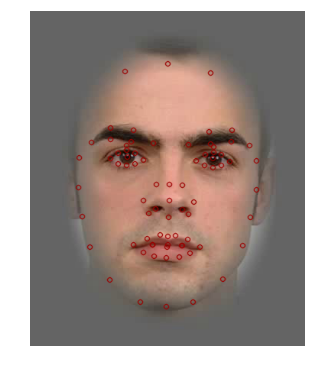

In [86]:
def stasm_demo(img='./img/fre99m30_frame_1.jpg', crop=True, conv_hull=False):
    points = locator.face_points(img, add_boundary_points=False)
    im = cv2.imread(img)
    
    if cv2.__version__[0] == '3': # taking care of changed cv-API
        outcol = cv2.COLOR_BGR2RGB
        lt = cv2.LINE_AA
    else:
        outcol = cv2.cv.CV_BGR2RGB
        lt = cv2.CV_AA
    
    if conv_hull:
        hull = cv2.convexHull(points)
        cv2.polylines(im, [hull], True, (155,0,0), thickness=1, lineType=lt)
        
    for point in points:
        cv2.circle(im, (point[0], point[1]), 3, (0,0,155), thickness=1, lineType=lt)
    
    if crop:
        y, h, x, w = 110, 440, 70, 360
        im = im[y:y+h, x:x+w]
  
    im = cv2.cvtColor(im, outcol)
    return im

im = stasm_demo()
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(im)
plt.show()

### Step 2.2: Find Face Area

This proved a little difficult for at least two reasons: **First**, the position of STASM's three 'hairline points' is quite inacurrate (at least their height). Quite often, they are too low. **Second**, it is not enough to just connect the outer points. OpenCVs `convexHull` function does that.

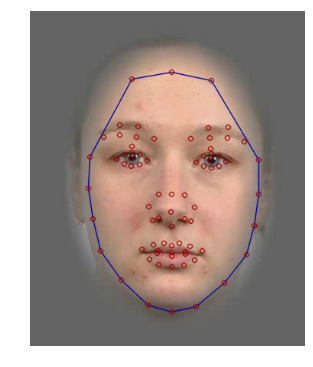

In [85]:
im = stasm_demo(img='./img/fre99w22_frame_1.jpg', conv_hull=True)
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(im)
plt.show()

Rather, to get as close as possible to the 'egg' shape of a typical face, I merge two ellipses. To see how this works, look at the specific distribution of some points returned by STASM:

![stasm_loc](./stasm_loc.jpg)

I first find the line connecting point 0 and point 12 (called `left_`and `right_center_point` in the code below), as well as point 6 (`chin`) and 14 (`forehead_tip`). Those two axes yield a central point (`center`) that is in close proximity to point 52 (`nosetip`). The bottom ellipse is generated with this point as the center and the length of the axes as its diameter (the 'narrower' part of the face-egg). The top ellipse is moved up a bit, the vertical diameter stretched and the horizontal diameter compressed (the 'wider' part of an egg).

The function right now looks like this:

In [79]:
def annotate_face(img='./img/fre99m36_frame_1.jpg', y_offset=50, crop=True):
    
    if cv2.__version__[0] == '3': # taking care of changed cv-API
        outcol = cv2.COLOR_BGR2RGB
        lt = cv2.LINE_AA
    else:
        outcol = cv2.cv.CV_BGR2RGB
        lt = cv2.CV_AA
    
    im = cv2.imread(img)
    im_orig = im.copy()
    points = locator.face_points(img)
    
    nosetip = points[52]
    left_center_point = points[0]
    right_center_point = points[12]
    chin = points[6]
    forehead_tip = points[14]
    
    width = right_center_point[0] - left_center_point[0] + 5
    center_x = (right_center_point[0] + left_center_point[0]) / 2
    
    height = chin[1] - forehead_tip[1]
    center_y = (chin[1] + forehead_tip[1]) / 2
    
    center = [center_x, center_y]
    
    el_bottom = cv2.ellipse2Poly((center_x, center_y), (width/2, height/2), 0,0,360,4)
    el_top = cv2.ellipse2Poly((center_x, center_y - 25), ((width/2) + 5, (height/2)-10), 0,0,360,4)
    el_total = cv2.convexHull(np.vstack([el_top, el_bottom]))
    
    cv2.polylines(im, np.int32([el_bottom]), True, (10,200,200), thickness=2, lineType=lt)
    cv2.polylines(im, np.int32([el_top]), True, (255,255,255), thickness=2, lineType=lt)
    cv2.polylines(im, el_total, True, (0,0,233), thickness=6, lineType=lt)
    
    for point in points[0:16]:
        cv2.circle(im, (point[0], point[1]), 3, (100,55,55), thickness=1)
    cv2.circle(im, (nosetip[0], nosetip[1]), 3, (100,55,55), thickness=2, lineType=lt)
    cv2.circle(im, (center_x, center_y), 3, (0,0,233), thickness=2, lineType=lt)
       
    if crop:
        y, h, x, w = 110, 440, 70, 360
        im = im[y:y+h, x:x+w]
        
    im = cv2.cvtColor(im, outcol)
    
    return im

The code below demonstrates this approach. The red dotted circle is the 'egg' - the combination (or outer envelop) of the bottom ellipsis (yellow) an the top one (white). The red dot is the centerpoint of the bottom ellipse, the blue one is point 52 found by STASM, what the algorithm considers the tip of the nose. As you can see, this approach does not work well with all identities.

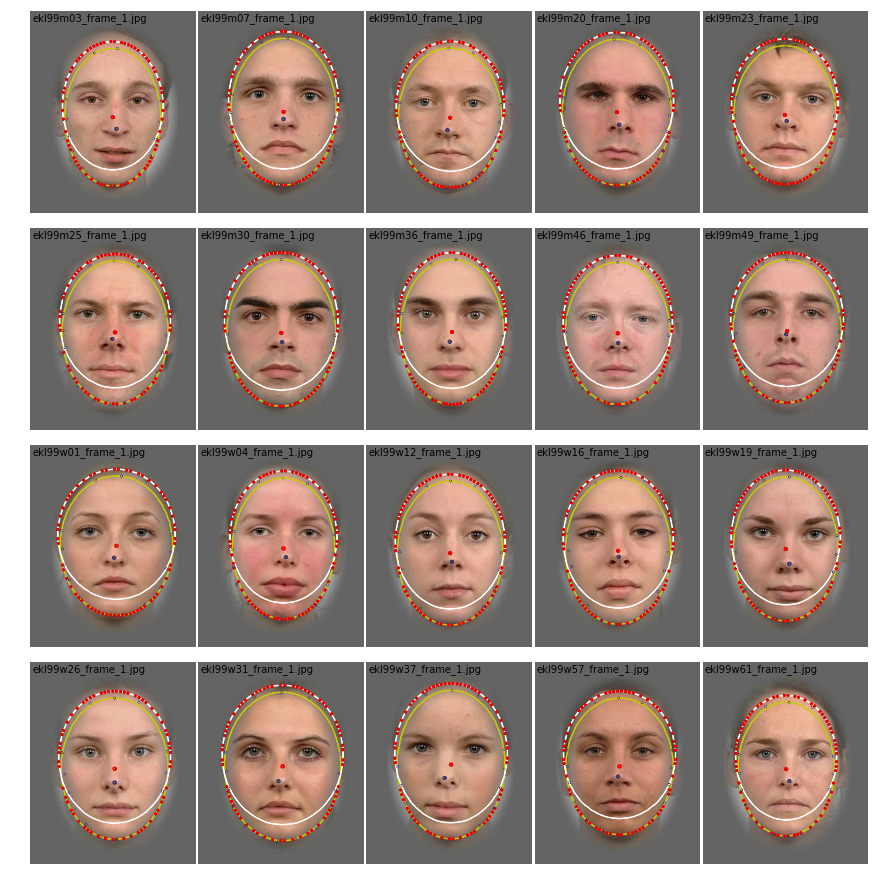

In [81]:
img_flist = os.listdir('./img')

n_rows = 4
n_cols = 5
step = 2
plt.figure(figsize=(n_cols*3,n_rows*6))
for i in xrange(n_rows*n_cols):
    im_idx = i * step
    im = annotate_face(os.path.join('./img/',img_flist[im_idx]))
    plt.subplot(n_rows,n_cols, i + 1)
    plt.axis('off')
    plt.imshow(im)
    plt.text(4, 20, img_flist[im_idx], fontsize=10)

# adjust whitespace between subplots
left, right, bottom, top = 0.125, 0.9, 0.5, 1
wspace, hspace = 0.02, 0.02
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

One identity (w14) poses a special problem as she is the only one were hair covers a considerable part of the forehead. Here we will need to adjust the facial area manually as the automatic solution does not look very well:
    

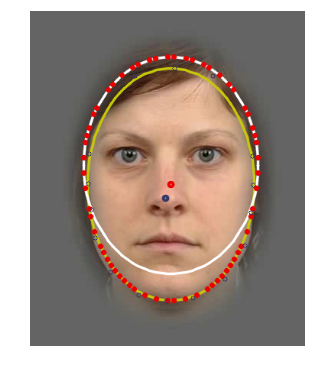

In [80]:
im = annotate_face('./img/fre99w14_frame_1.jpg')
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(im)
plt.show()